# Analyzing Energy Use & Predicting Emissions Of Buildings In NYC
------

## Contents

__[1. Introduction](#first-bullet)__

__[2. Exploratory Analysis](#second-bullet)__

__[3. Analysis Of Multifamily Buildings ](#third-bullet)__

__[4. Predictive Models For Green House Gas Emission ](#fourth-bullet)__

__[5. Conclusions And Recommendations ](#fifth-bullet)__


--------------

## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
I originally started this project as a data challenge to take the 2016 NYC Benchmarking Law data about building energy usage and do something interesting with it.  After the interview process was over, I kept coming back to this dataset and thinking about it more. After a few iterations I thought it might be interesting to see if we could be able to predict the emission of green house gases from buildings by looking at their age, energy and water consumption as well as other energy consumption metrics. In the modeling section we look at three different modes for predicting green house gas emissions:

1. Linear Regression

2. Generalized Additive Models

3. Gradient Boosted Regression Trees


----------
### Data 
----------
The NYC Benchmarking Law requires owners of large buildings to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. This data gives building owners about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.  In this blog post we will analyze how buildings in New York City use energy and water, make recommendations on how to improve their performance and also model their green house gas emissions. The source code for this project can be found <a href="https://github.com/mdh266/NYCBuildingEnergyUse">here</a>.


Benchmarking data is also disclosed publicly and can be found <a href="http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml">here</a>.  I analyzed the 2016 data and my summary of the findings and recommendations for reducing energy consumption in New York City buildings are discussed in the conclusions section.

The 2016 data is very messy and a lot of cleaning was necessary to do analysis on it.  One thing to note is that this is **self-reported data**, meaning the performance data wasn't collected by a non-bias third party but by the building owners.  This means our data is mostly liekly biased and we will keep this in mind while performing out analysis.

There are about 13,223 buildings recorded in this dataset and many of them have missing data values. The cleaning process was made more difficult because the data was stored as strings with multiple non-numeric values which made converting the data to its proper type a more involved process.

--------------------------
## Exploratory Analysis<a class="anchor" id="second-bullet"></a>
-------------------------
Since the cleaning was more tedious I created external functions do handle this processes.  In addition, I also a created functions to handle transforming and plotting the data.  I kept these functions in seperate files <code>Cleaning_Functions.py</code> and <code>Plotting_Functions.py</code> respecively so as to not clutter the post.  We import these functions along with other basic libraries (<a href="http://pandas.pydata.org/">Pandas</a>, <a href="http://matplotlib.org/">Matplotlib</a> and <a href="http://seaborn.pydata.org/">Seaborn</a>) as well as read in the data file below:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from Cleaning_Functions import (initial_clean, 
                                convert_GeoPandas_to_Bokeh_format,
                                group_property_types)
                                
from Plotting_Functions import (plot_years_built, 
                                make_interactive_choropleth_map)

# Here we specifify a few data types as integers while reading in the Excel
df_2016 = pd.read_excel("data/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
                       converters={'Street Number':int, 
                                   'Zip Code':int,
                                   'Year Build':int,
                                   'ENERGY STAR Score':int})

There are about 13,233 buildings with different types of energy usage, emissions and other information.  I'll drop a bunch of these features and only keep the following,

- Reported NYC Building Identification Numbers : [BINs]
- NYC Borough, Block and Lot : [BBL]
- Street Number : [Street_Number]
- Street Name : [Street_Name]
- Zip Code : [Zip_Code]
- Borough : [Borough]
- Year Built : [Year_Built]
- DOF Benchmarking Status :[Benchmarking_Status]
- Site EUI (kBtu/ft$^{2}$) : [Site_Eui]
- Natural Gas Use [N(kBtu) : [Nat_Gas]
- Electricity Use (kBtu):  [Elec_Use]
- Total GHG Emissions (Metric Tons CO2e) : [GHG]
- ENERGY STAR Score : [Energy_Star]
- Water Use (All Water Sources) (kgal) : [Water_Use]

The terms in the square brackets are the column names used in the dataframe. In addition, we must do some basic feature engineering.  The reported data gives us the metrics (`NAT_Gas`, `Elec_Use`, `GHG`, `Water_Use`) in terms of total volume. Using these metrics in comparing buildings of different sizes is not a fair comparison.  In order to compare them fairly we must standardize these metrics by dividing by the square footage of the buildings giving us each metrics' intensity. We therefore have the following features,


- Nautral Gas Use Intensity (kBtu/ft$^{2}$) : [NGI]
- Electricty Use Intensity (kBtu/ft$^{2}$) : [EI]
- Water Use Intensity (kga/ft$^2$) : [WI]
- Total GHG Emissions Intensity (Metric Tons CO2e / ft$^2$) : [GHGI]
- Occupancy Per Square Foot (People / ft$^2$) : [OPSQFT]


I wrote a basic function called <code>initial_clean()</code>. to clean the data create the additional features. We call it on our dataset and then get some basic statistics about the data:

In [2]:
df_2016_2 = initial_clean(df_2016)
temp_cols_to_drop = ['BBL','Street_Number','Zip_Code','Occupancy']

df_2016_2.drop(temp_cols_to_drop, axis=1)\
         .describe()

,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT
count,9535.000000,11439.000000,1.008700e+04,1.142500e+04,1.147800e+04,7.265000e+03,9870.000000,11206.000000,7261.000000,11258.000000,11311.000000
mean,57.735711,525.733377,2.520461e+07,8.201496e+06,6.952577e+03,2.579751e+04,137.705639,54.266179,0.161268,0.031272,0.001065
std,30.143817,10120.105154,1.194068e+09,1.214643e+08,1.692231e+05,5.860239e+05,7512.527146,1210.530111,2.053453,0.571378,0.000536
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,65.300000,8.915501e+05,1.045702e+06,3.420250e+02,2.661700e+03,7.324853,13.682696,0.028523,0.004308,0.000629
50%,63.000000,82.400000,4.067600e+06,1.885996e+06,5.198000e+02,4.745600e+03,46.268145,18.482229,0.046098,0.005455,0.001075
75%,83.000000,103.000000,6.919267e+06,4.513704e+06,9.394500e+02,8.057900e+03,68.036285,30.716894,0.073287,0.007003,0.001525
max,100.000000,801504.700000,1.101676e+11,1.047620e+10,1.501468e+07,4.385740e+07,737791.764249,84461.681703,98.340480,39.190314,0.001999


The above table is only a summary of the numrical data in the dataframe. Just looking at the <code>count</code> column we can immediately see that there are a lot of missing valus in this data. This tells me that this data will be rather messy with many columns having NaNs or missing values.

*It also looks like there is a lot of variation within this dataset.  Just looking at the <code>Site_EUI</code> statistic, the 75th percentile is is 103 (kBtu/ft²), but the max is 801,504.7 (kBtu/ft²).  This probably due to the number of different types of buildings in the city, as well as the fact that the data is biased due to the fact it is self-reported*


The next thing I would like to see is how many of the buildings in NYC are passing the Benchmarking Submission Status:

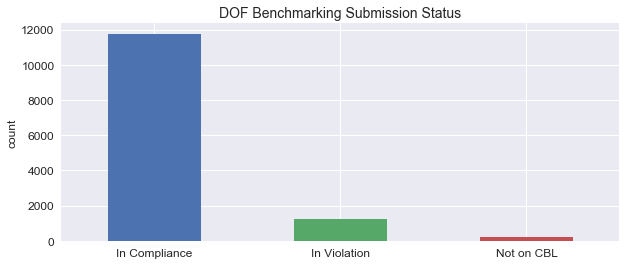

In [3]:
plt.figure(figsize=(10,4))
df_2016_2['Benchmarking_Status'].value_counts()\
                                .plot(kind='bar',
                                      fontsize=12,
                                      rot=0)
    
plt.title('DOF Benchmarking Submission Status',fontsize=14)
plt.ylabel('count',fontsize=12)

Most buildings are in compliance with the Department of Finance Benchmarking standards. Let's take a look at the violators:

In [4]:
Violators = df_2016_2[df_2016_2.Benchmarking_Status == 'In Violation']
Violators.head()

,BBL,BINs,Street_Number,Street_Name,Zip_Code,Borough,Benchmarking_Status,Property_Type,Year_Built,Occupancy,...,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT
11978,2.051410e+09,NaN,300,BAYCHESTER AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11979,3.088400e+09,NaN,3939,SHORE PARKWAY,11235,Brooklyn,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11980,3.088420e+09,NaN,2824,PLUMB 3 STREET,11235,Brooklyn,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11981,2.051411e+09,NaN,2100,BARTOW AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11982,2.051410e+09,NaN,312,BAYCHESTER AVENUE,10475,Bronx,In Violation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There's not much we can learn from this, if we can look to see if certain zip codes have more buildings in violation.  First thing we do is group by the zip codes and count them to get the number of violations per zip code:

In [5]:
zips_df = Violators.groupby('Zip_Code')['Zip_Code'].size()\
                   .reset_index(name='counts')

Now we want to visualize the the number of violators per zip code. To make things interesting we will create an interactive choropleth map using the <a href="https://bokeh.pydata.org/en/latest/">Bokeh</a> Library.  Bokeh is a great vizualization tool that I have used in the <a href="http://michael-harmon.com/blog/IntroToBokeh.html">past</a>.  We get the shapes for New York City zip codes as a geojson file from this <a href="http://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas">site</a>.  The geojson file can be read into a dataframe using <a href="http://geopandas.org/">GeoPandas</a>.

In [6]:
import geopandas as gpd
gdf = gpd.read_file("data/nyc-zip-code-tabulation-areas-polygons.geojson")

# GeoPandas doesn't allow users to convert the datatype while reading it in so we do it here
gdf["postalCode"] = gdf["postalCode"].astype(int)

We can see the basic contents of the GeoPandas dataframe:

In [7]:
gdf.head()

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
0,1,11372,Jackson Heights,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,POLYGON ((-73.86942457284177 40.74915687096788...
1,2,11004,Glen Oaks,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,POLYGON ((-73.71132911125308 40.74947450816085...
2,3,11040,New Hyde Park,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.703443,40.748714,POLYGON ((-73.70098278625547 40.73889569923034...
3,4,11426,Bellerose,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.724004,40.736534,POLYGON ((-73.72270447144122 40.75373371438336...
4,5,11365,Fresh Meadows,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.794626,40.739903,"POLYGON ((-73.81088634744756 40.7271718757592,..."


I noticed only a few of the zipcodes had actual names, so I wrote a script (`getNeighborhoodNames.py`) to scrape <a href="https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm">this website</a> to obtain each neighborhood's name.  I pickled the results so we could use them here:

In [8]:
zip_names = pd.read_pickle("data/neighborhoods.pkl")

We can attach them to our GeoPandas dataframe by joining them (on zip code),

In [9]:
gdf = gdf.drop(['PO_NAME'],axis=1)\
         .merge(zip_names, on="postalCode",how="left")\
         .fillna("")

Next, we'll left join our count of violators-per-zipcode <code>zips_df</code> to above dataframe and fill in the zip codes that do not have violations with zeros:

In [10]:
gdf= gdf.merge(zips_df, how="left", left_on="postalCode", right_on="Zip_Code")\
         .drop(["OBJECTID","Zip_Code"], axis=1)\
         .fillna(0)

gdf.head(2)   

,postalCode,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,PO_NAME,counts
0,11372,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,POLYGON ((-73.86942457284177 40.74915687096788...,West Queens,5.0
1,11004,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,POLYGON ((-73.71132911125308 40.74947450816085...,Southeast Queens,0.0


Now before we can use Bokeh to visualize our data we must first convert the GeoPandas dataframe to a format that Bokeh can work with. Since I already covered this in a previous blog <a href="http://michael-harmon.com/blog/IntroToBokeh.html">post</a> I won't go over the details, but here I used a slightly modified version of the function from that post:

In [11]:
bokeh_source = convert_GeoPandas_to_Bokeh_format(gdf)

Next we set bokeh `io` module to be in the notebook and use the function I wrote <code>make_interactive_choropleth_map</code> to create the in-notebook zipcode choropleth map:

In [12]:
from bokeh.io import output_notebook, show
output_notebook()

# We get the min and max of the number of violations to give the cloropleth a scale.
max_num_violations = zips_df['counts'].max()
min_num_violations = zips_df['counts'].min()

fig = make_interactive_choropleth_map(bokeh_source,
                                      count_var="Number Of Violations",
                                      min_ct=min_num_violations,
                                      max_ct=max_num_violations)
show(fig)

Loading BokehJS ...

You can hover your mouse over the each of the zipcode and the map will display the neighborhood name and number of violations. From this we can see that Chelsea, Downtown Brooklyn and Long Island City neighborhood have the highes number of violations.

The fact that different neighborhoods have different numbers of violating buildings gives us the suspicion that **the neighborhood may be correlated with the buildings energy usage**, this could be because of building owners that are in voliation owning multiple buildings on a single lot or neighrborhood.

Now let's move back to analyzing the buidlings that are not in violation.  First let's see the distributution of all buildings that are in different ranges of the <code>Energy Star</code> ratings:

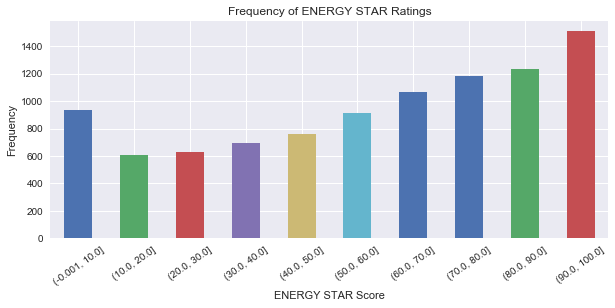

In [13]:
bins = [0,10,20,30,40,50,60,70,80,90,100]

df_2016_2['Energy_Star'].value_counts(bins=bins)\
                            .sort_index()\
                            .plot(kind='bar',
                                  rot=35,
                                  figsize=(10,4),
                                  title='Frequency of ENERGY STAR Ratings')
plt.ylabel('Frequency')
plt.xlabel('ENERGY STAR Score')

We can see that the majority are within the 50-100 range, but a almost 1000 buildings have scores inbetween 0 and 10. Let's take a look at the distribution of building types.  We will just take the top 10 most common building types for now..

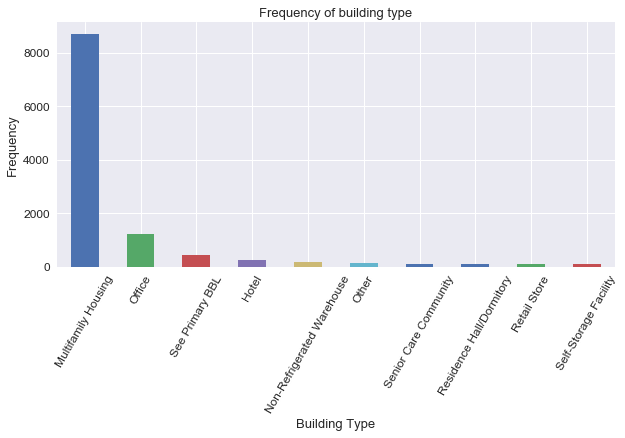

In [14]:
df_2016_2['Property_Type'].value_counts()\
                          .head(10)\
                          .plot(kind='bar',
                                figsize=(10,4.5),
                                fontsize=12,
                                rot=60)
        
plt.title('Frequency of building type', fontsize=13)
plt.xlabel('Building Type',fontsize=13)
plt.ylabel('Frequency',fontsize=13)

The most common buildings in NYC are multifamily housing, then offices, other, hotels and somewhat suprisingly non-refrigerated warehouse space.  I would have thought that there would be more schools and retail spaces than warehouses or dormitorites in New York City, but I don't know what the <code>Primaty BBL</code> listing is.


Let's look at the Energy Star ratings of buildings across different building types, but first how many different building types are there?  We can find this out,

In [15]:
print("Number of building types are: {}".format(len(df_2016_2['Property_Type'].unique())))

Number of building types are: 54


This is too many building types to visualize the Energy Star Score (<code>Energy_Star</code>) of each, we'll just look at just 5 building types, lumping the 54 into the categories into either:
- Residential
- Office
- Retail
- Storage
- Other

I built a function to group the buildings into the 5 types above called <code>clean_property_type(...)</code> and we use it below to transform the Pandas Series:

In [16]:
Property_Type = df_2016_2.copy()
Property_Type['Property_Type'] = Property_Type['Property_Type'].apply(group_property_types)

Now we can look at the  <code>Energy_Star</code> (score) of each of the grouped buildings types:

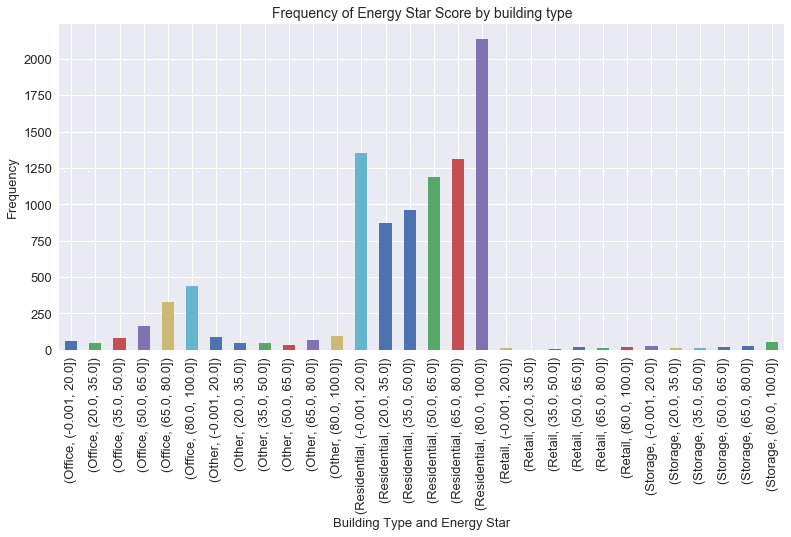

In [17]:
bins2 = [0,20,35,50,65,80,100]

Energy_Star_Scores = Property_Type.groupby(['Property_Type'])['Energy_Star']

Energy_Star_Scores.value_counts(bins=bins2)\
                  .sort_index()\
                  .plot(kind='bar',
                        figsize=(13,6),
                        fontsize=13)

plt.title('Frequency of Energy Star Score by building type',fontsize=14)
plt.xlabel('Building Type and Energy Star', fontsize=13)
plt.ylabel('Frequency', fontsize=13)

Overall it looks like residential buildings have a lot more proportion of low Energy Star Scoring buildings when compared to office buildings. This is probably because there are much more older residential buildings than office spaces in New York City. We'll look at the distribution of the years in which builings of just properties of type: 'Multifamily Housing' and 'Office' were built:

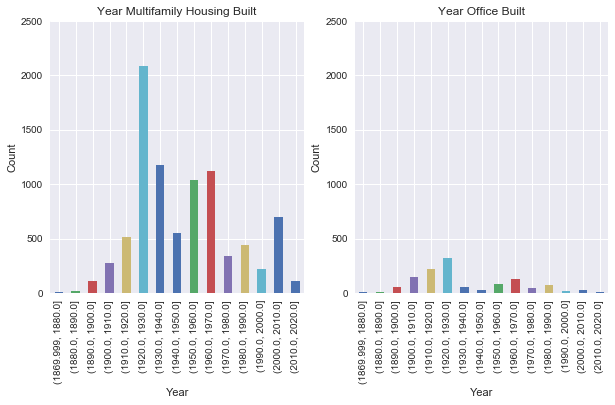

In [18]:
plot_years_built(df_2016_2)

It seems like it's the opposite of what I thought, but the number of residential buildings is much higher and the majority were built right before and right after World War 2, as well as in the 2000s.  The same is true about offices, however, without the uptick in the early 2000s.

Let's just focus on the multifamily housing and see what we can find out about them since they may offer the best return on investment in terms of improving energy efficiency.

-------------------------------------
## Analysis Of  Multifamily Buildings <a class="anchor" id="third-bullet"></a>
--------------------------------------

First let's look at the summary statistics of just the mulitfamily housing:

In [19]:
Multifamily_Buildings = df_2016_2[df_2016_2['Property_Type'] == 'Multifamily Housing']

Multifamily_Buildings.drop(temp_cols_to_drop, axis=1)\
                     .describe()

,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT
count,7513.000000,8654.000000,7.914000e+03,8.643000e+03,8.669000e+03,5.499000e+03,7704.000000,8432.000000,5497.000000,8457.000000,8487.000000
mean,56.629842,405.938456,2.991518e+07,4.536019e+06,4.093800e+03,1.193724e+04,164.160356,31.980654,0.107960,0.021024,0.001122
std,30.477155,9520.852245,1.347821e+09,5.199372e+07,8.535570e+04,8.786550e+04,8502.255602,495.657557,0.905276,0.470851,0.000517
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,67.900000,1.249754e+06,9.817544e+05,3.419000e+02,3.146700e+03,10.052411,13.248499,0.035663,0.004370,0.000696
50%,61.000000,82.900000,4.429401e+06,1.539532e+06,4.928000e+02,5.100200e+03,52.311449,16.720334,0.051203,0.005358,0.001149
75%,83.000000,101.100000,7.227774e+06,3.000909e+06,8.164000e+02,8.046100e+03,70.215899,22.614394,0.077178,0.006656,0.001558
max,100.000000,801504.700000,1.101676e+11,3.729784e+09,5.860677e+06,3.638813e+06,737791.764249,35863.305400,52.143200,39.190314,0.001999


We can see again, large variations in the energy data, with most of it being between 0 and some fixed number and then atleast one outlier.  Comparing multifamily housing to all buildings in NYC (previous table) we can see that all of the mean value and variation of the energy, water and emission rates are lower for multifamily housing buildings than overall buildings in NYC.


Now let's take a look at how the performance metrics relate to one another by plotting the correlation matrix. But first, since we have so much missing data, let's find the total number of multifamily buildings and the number of multifamily buildings without missing data.

In [20]:
cols_to_drop = ['BBL','BINs','Street_Number','Street_Name', 'Occupancy',
                'Borough','Benchmarking_Status','Property_Type']

X = Multifamily_Buildings.drop(cols_to_drop,axis=1)
X_clean = X.dropna()

print("Total Multifamily Buildings: {}".format(X.shape[0]))
print("Total Multifamily Buildings without missing data: {}".format(X_clean.shape[0]))

Total Multifamily Buildings: 8699
Total Multifamily Buildings without missing data: 4407


About half of the multifamily buildings have missing data, that's significant.  Let's plot the correlation matrix to see how correlated are features are on the all the multifamily buildings.  Note that we first have to normalize the data.

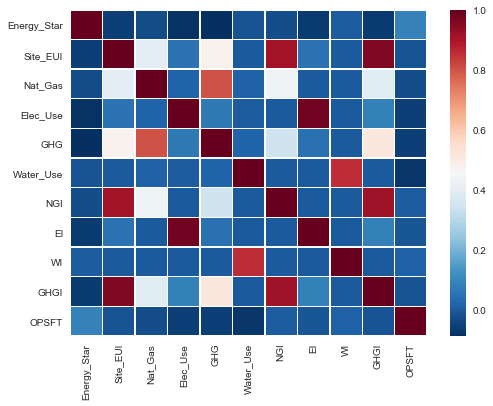

In [21]:
X_s = (X - X.mean())/X.std()

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(X_s.corr(),
            linewidths=.5,
            cmap="RdBu_r")

We can see that,

- **Natural gas usage is fairly strongly correlated to green house emission rates which makes sense.**


- **Energy usage intensity is strongly correlated with natural gas intensity, which again makes sense, since gas is a primary form of heating.**

What doesn't make sense to me is that *the energy star score is weakly correlated to any of the measures of energy, water or emissions*.  This is strange to me because a higher energy star score is supposed to reflect more efficient use of energy and water.  Furthermore, the energy star score goes up (slightly) when the density of occupants increases, and the energy star rating should be independent of occupancy density since it is a property of the physical building and not the buildings' tenants.

We can see how the results change when we only use multifamily building data that do not have missing values:

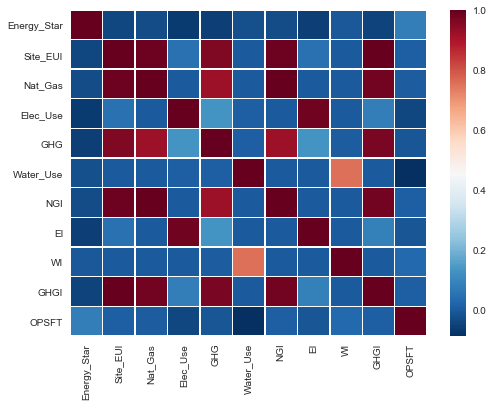

In [22]:
# I don't want to scale the years since I will eventually treat them as a categorial variable
year_built         = X_clean['Year_Built'].to_frame()
X_clean_wo_year    = X_clean.drop('Year_Built',axis=1)

X_s_clean  = (X_clean_wo_year  - X_clean_wo_year.mean())/X_clean_wo_year.std()

# Now get the year built back with a left join
X_s_clean  = X_s_clean.merge(year_built,
                             left_index=True,
                             right_index=True,
                             how = "left")

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(X_s_clean.corr(),
            linewidths=.5,
            cmap="RdBu_r")

The previously mentioned correlations are now stronger, but there is still too weak a correlation between energy star score and energy or water usage for my liking.  We'll have to dig deeper into the data to see if there are outliers that are affecting our correlation matrix.

### Outlier Removal
In this section we'll be looking at scatter plots of various features against the `Site_EUI` to try to identify outliers in the data. 

Let's look at the scatter plot of natural gas intensity and energy usage intensity to see if we can observe outliers that may be affecting our correlation matrix.  *The reason we are doing so is that we suspect energy usage intensity should be highly correlated to natural gas intensity since natural gas is used for cooking and heating.*

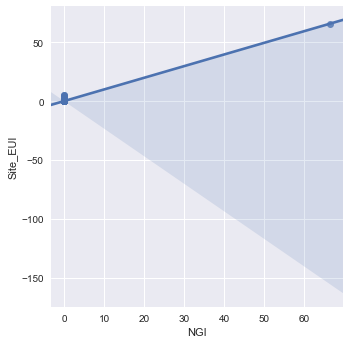

In [23]:
sns.pairplot(X_s_clean, 
             x_vars='NGI',
             y_vars='Site_EUI',
             kind='reg',
             size=5,
             dropna=True)

We can see that are some signficant outliers in our data.  Experimenting with different values i was able to remove them and a clearer relationship between the natural gas usage and EUI:

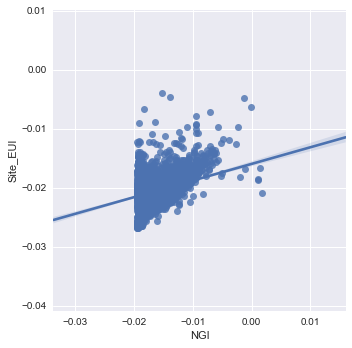

In [24]:
X_s_Nat_Gas = X_s_clean[(X_s_clean.NGI < 0.02) & (X_s_clean.Site_EUI < 0.01)]

sns.pairplot(X_s_Nat_Gas, 
             x_vars='NGI',
             y_vars='Site_EUI',
             kind='reg',
             size=5,
             dropna=True)

We can see that **buildings that have higher natural gas usage per sqft have a higher energy intensity and this makes sense!** I repeat the same procedure for electricity usage intensity and EUI since again, we would think they should be positively correlated:

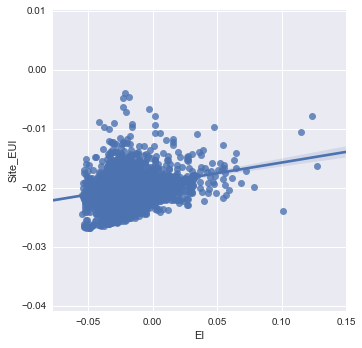

In [28]:
X_s_Elec_Use = X_s_clean[(X_s_clean.EI < 0.5) & (X_s_clean.Site_EUI < 0.01)]

sns.pairplot(X_s_Elec_Use, 
             x_vars='EI', 
             y_vars='Site_EUI', 
             kind='reg', 
             size=5,
             dropna=True)

We again see that **buildings with higher electricity per square foot have a higher energy usage intensity.** 

Now we do the same for water usage intensity and EUI.  While it might not seem water and energy usage could be correlated with energy usage intensity, often water is used for heating and cooling:

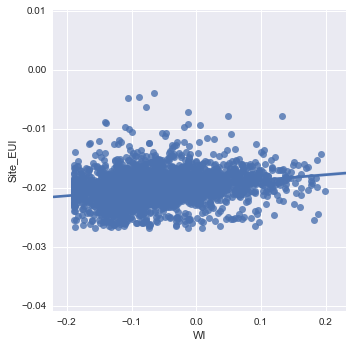

In [29]:
X_s_Water_Use = X_s_clean[(X_s_clean.WI < 0.2) & (X_s_clean.Site_EUI < 0.01)]

sns.pairplot(X_s_Water_Use,
             x_vars='WI', 
             y_vars='Site_EUI',
             kind='reg',
             size=5, 
             dropna=True)

Interestingly, here we see a slighly weaker positive correlation, meaning **buildings which use more water per square foot only have marginarly higher energy usage intensity.** Lastly we repleat the procedure for green house has emission intensity, since you would think that if a building is more energy intensive it has a much larger carbon foot print.

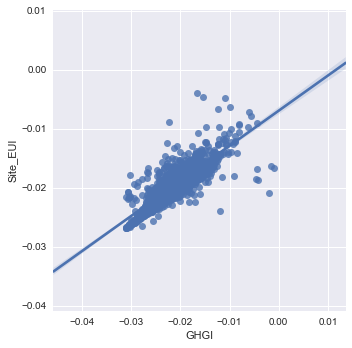

In [31]:
X_s_GHG = X_s_clean[(X_s_clean.GHGI < 0.02) & (X_s_clean.Site_EUI < 0.01)]

sns.pairplot(X_s_GHG,
             x_vars='GHGI', 
             y_vars='Site_EUI',
             kind='reg',
             size=5, 
             dropna=True)

Indeed this is true!  Green house gas emissions are highly correlated to energy usage intensity; infact its almost linearly related! This means

- ** We may be able to approximate a multifamily buildings green house gas emission with its energy intensity usage!**


Now, lets make a dataframe that has all the removed outliers and the EUI vs. natural gas, electricity, water and green house gas emission intensity below:

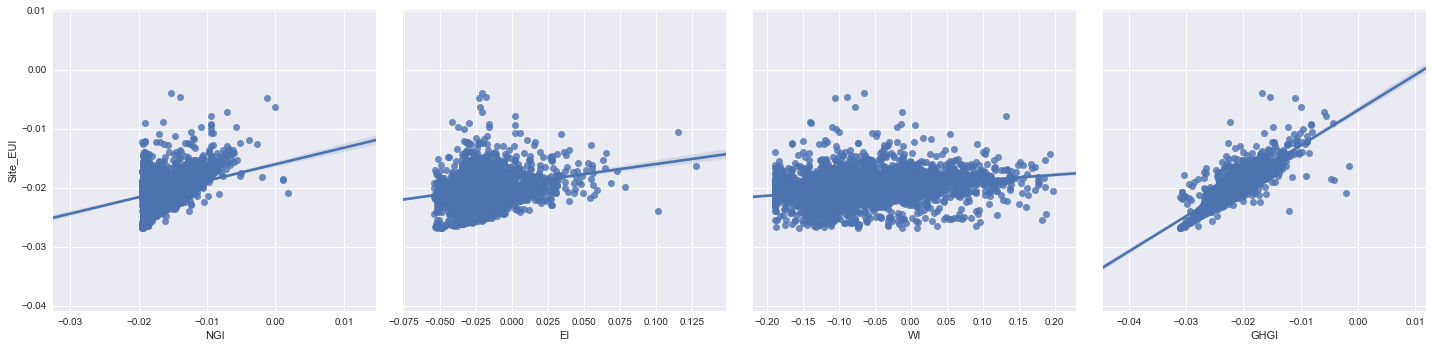

In [32]:
X_outliers_removed = X_s_clean[(X_s_clean.NGI      < 0.02) &
                               (X_s_clean.EI       < 0.5)  &
                               (X_s_clean.WI       < 0.2)  &
                               (X_s_clean.GHGI     < 0.02)  &
                               (X_s_clean.Site_EUI < 0.01)]

sns.pairplot(X_outliers_removed, 
             x_vars=['NGI','EI','WI','GHGI'], 
             y_vars='Site_EUI', 
             kind = 'reg',
             size=5, 
             dropna=True)

It look's like EUI is very positively correlated to the green house gas emission intensity and natural gas usage intensity.  The relationship between EUI is slightly less strongly correlated to electricity usage intensity and even less so with water usage intensity.  

We can also see from the plot below that the site **EUI was not very correlated to the year that the buildings were constructed.**  Most likely this is because so many were built around the same time period.

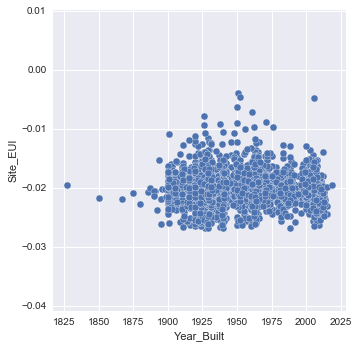

In [33]:
sns.pairplot(X_outliers_removed, 
             x_vars='Year_Built', 
             y_vars='Site_EUI', 
             size=5, 
             dropna=True)

Now that we have removed some outliers we now have multifamily buildings that have very similar characteristis. We can visualize the correlation matrix to try to gleam some insights into improving these building energy efficiency.

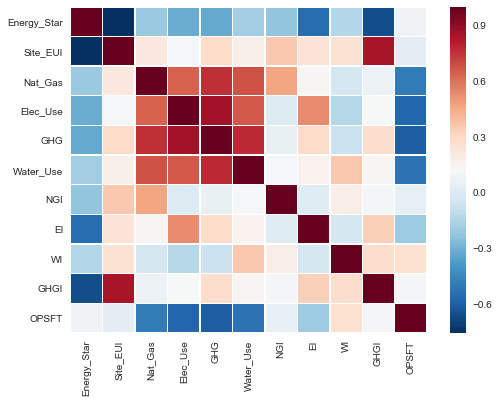

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(X_outliers_removed.corr(),
            linewidths=.5,
            cmap="RdBu_r")

This is a much more belivable correlation matrix than the previous two we looked at!!

*We can see that the Energy Star score is very negatively correlated with enery usage intensity, which make sense as the energy star score is a measure of energy efficiceny of the building.* Furthermore the Energy Star score is negatively correlated with electricity, water, and natural gas usage intensity as well as green house gas emission intensity which makes sense. Additionally, we see that **Energy Star Score is independent of occupancy per square foot which makes sense since it is a fucntion of the building's efficiency and not the people inside of it.**

We should note that the number of buildings in this case is,

In [35]:
print("Total Multifamily Buildings in reduced data: {}".format(X_outliers_removed.shape[0]))

Total Multifamily Buildings in reduced data: 4311


We see that removing outliers only removed 94 buildings or about 2% of the buildings, a small price to pay for getting much more informative data!  

Since energy usage intensity is almost linearly correlated with green house gas emissions we should be able to predict the green house gas emissions of a bulding from its energy intensity usage.  However, the energy usage intensity might not always be readily available and instead we'll see if we can predict the green house gas emissions directly using the other energy consumption characteristics of the buildings.

## Predictive Models For Green House Gas Emissions <a class="anchor" id="fourth-bullet"></a>

Now let's build a predictive model for green house gas Emissions by multifamily homes in New York City.  We'll do this at first using a simple linear regression model.  While not the best in terms of perdictive performance it is often a best first step since it allows one to interpet the effect each feature has on the predicted green house gas emissions.  

Befe doing building a model we first have to prepare our features and scale them appropriately. This involves dictating which are the continuous variabels and the categorical variables.  We define them as,

In [36]:
continuous_vars  = ["NGI", "EI", "WI", "GHGI", "OPSFT","Site_EUI"]
df_cont          = X_clean[continuous_vars]

categorical_vars = ["Year_Built", "Zip_Code", "Energy_Star"]
df_cat           = X_clean[categorical_vars]

Now we scale our continuous variables,

In [37]:
df_cont_s = (df_cont - df_cont.mean() ) / df_cont.std()

We now declare make our categorical variables. Note that we defined the year built and energy star rating as ordered categorical variables since there is a natural ordering for them, however, zipcode has no natural ordering.

In [38]:
df_cat["Zip_Code"]    = df_cat["Zip_Code"].astype("category",    ordered=False)
df_cat["Year_Built"]  = df_cat["Year_Built"].astype("category",  ordered=True)
df_cat["Energy_Star"] = df_cat["Energy_Star"].astype("category", ordered=True)

Now we can merge the two dataframes back together on their index

In [39]:
df_s = df_cont_s.merge(df_cat,
                       left_index=True,
                       right_index=True)

Now we can filter the oultiers and define our training and test set. 


*Note that we drop the site EUI since it is highly correlated to other features.  Although this is most correlated to green house gas emissions, it might be harder to measure, so we remove it for now to see how well we can do without it.*

In [40]:
df_s = df_s[(df_s.NGI   < 0.02)    &
            (df_s.EI    < 0.5)     &
            (df_s.WI       < 0.2)  &
            (df_s.GHGI     < 0.02) &
            (df_s.Site_EUI < 0.01)]

# target variable is green house gas emission
y = df_s["GHGI"]

# features are all the other
X = df_s.drop(["GHGI", "Site_EUI"], axis=1) #,"Zip_Code","OPSFT","Site_EUI"],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Linear Regression

As we stated early we'll start out with a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression Model</a> since it is simple and interpertable. The form of a linear regression model is,

$$ y \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p}$$


The $x_{i}$'s are the features for our model (`WI`, `OPSFT`, etc) and $y$ is the green hour gas emission intensity (`GHGI`).  The coefficents ($\theta_{i}$) are estimated using ordinary least squares methods.  We can easily implement a least squares regression model using Scikit-learn:

In [41]:
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import r2_score

reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

We can then evaluate the model performance ($R^{2}$-score) on the test set to *see how much variance in the model we are able to explain,*

In [42]:
y_pred = reg.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.5349121926606044


We can explain 53% of the variance which definitely leaves room for improvement, but we expected that such a simple model would not perform well.  Let's take a look at which features are most important.

In [43]:
for coef in zip(X_train.columns, reg.coef_):
    print(coef)

('NGI', -0.049241909914102912)
('EI', 0.007461674695331726)
('WI', 0.0075256595439820023)
('OPSFT', 0.00027381965312541385)
('Year_Built', -1.6656295364058703e-05)
('Zip_Code', -7.4437735726882144e-08)
('Energy_Star', -7.0952846907978217e-05)


For features that have continuous values the model coefficents tell us that an increase on of their in units results in an incrase in the unit of green house emissions tha is equal to the coefficent.  We can see that increasing the electricty, water intensity and occupancy increase the green house gas emissions, which makes sense. *However, increases in natural gas intensity usage decreases the green house gas emisssions.*  This is strange, however, it could also be because of multi-collinarity of the features. 

Additionally, I'm not sure how green house gas emissions are calculated, if the calculations include the emissions from power sources this could make sense since electricity often comes from coal which releases more emissions that using natural gas.  Therefore switching to natural gas instead of electricity could reduce green house gas emissions. 


We can measure the p-values for coefficents by using Scikit-Learns's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html">f_regression</a> function.

In [44]:
from sklearn.feature_selection import f_regression

f_stats, pvals = f_regression(X_train, y_train)

for coef in zip(X_train.columns, pvals):
    print("{0}'s p-value : {1}".format(coef[0],coef[1]))

NGI's p-value : 8.665035837328126e-12
EI's p-value : 1.0211897417728831e-73
WI's p-value : 7.911400038587674e-52
OPSFT's p-value : 5.532133331056601e-08
Year_Built's p-value : 6.094175921650743e-11
Zip_Code's p-value : 1.6880007862868094e-13
Energy_Star's p-value : 0.0


**We see that even though the coeficients of the regression model are rather small, their small p-values signifiy that they are still signifcant and should be included in our model.**


Let's move on to a more flexible model and hopefully improve our predictions.

### Generalized Additive Models

Linear regression is a specific type of generalized linear model.  <a href="https://en.wikipedia.org/wiki/Generalized_linear_model">Generalized lienar models</a> relate the expected outcome of the target variable, $y$, to the model's features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[y]) \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

The function $g$ is called the **link** function. For linear regresion the link function is just the identity function, while for logistic regression it is the <a href="https://en.wikipedia.org/wiki/Logit">logit function</a>.

<a href="https://en.wikipedia.org/wiki/Generalized_additive_model">Generalized Additive Models </a>are extension of the generalized addative model that assume that the expected outcome of the target variable $y$ to the features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[y]) \; = \; \theta_{0} + f_{1}(x_{1}) + f_{2}(x_{2}) +  \ldots + f_{p}(x_{p}) $$

The basis functions $f_{i}$ can be functions of a parameteric form such as a polynomial, or more general non-parametric functions.  Using basis functions allows for smoother, higher order (more accurate) approximations to the model in parameter space when compared to traditional polynomials.  GAMs therefore allow for more accurate predictions than generalized linear models, however, they still allowing for the model to be interperable.  

We'll use the <a href="https://github.com/dswah/pyGAM">PyGam</a> library which uses penalized <a href="https://en.wikipedia.org/wiki/B-spline">B splines</a> as basis functions. This choice of basis functions allow us to automatically model non-linear relationships without having to manually try out many different transformations on each variable.

We can import the regression GAM model:

In [45]:
from pygam import LinearGAM
from pygam.utils import generate_X_grid

We can then fit our model using 10 splines and using a grid search:

In [46]:
gam = LinearGAM(n_splines=10).gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


PyGam gives a summary report of our model similar to the <a href="http://www.statsmodels.org/stable/index.html">StatsModels</a> library:

In [169]:
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     60.4554
Link Function:                     IdentityLink Log Likelihood:                             -446994875.062
Number of Samples:                         2888 AIC:                                         893989873.035
                                                AICc:                                        893989875.752
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                   0.6849
Feature Function   Data Type      Num

Evaluaating the performance of our model on the test set we find an $R^{2}$ score of:

In [47]:
y_pred = gam.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.680405023715229


The GAM model results in an improvement in the $R^2$ score!  We can see that using a more flexible model like a GAM using B-splines is better able to explain the variance in our data when compared to a linear regression model.

We can explore the effect that the number of splines used in our model has on the performance by training the model on various numbers of splines and plotting the learning curves.  We write a function to train a model and returns 1 - $R^2$ on the training and test set respectively.

In [48]:
def train_gam_full(X_train, y_train, X_test, y_test, n_splines):
    """
    Trains a linear GAM model and returns performance on training and test sets.
    
    :parameters:
    -----------
    X_train (DataFrame) : Training set of features
    y_train (Series)    : Training set target values
    X_test (DataFrame)  : Test set of features
    y_test (Series)     : Test set target values
    n_splines (int)     : The number of splines to use in the GAM
    
    :returns: 
    --------
    The tupple of (1-R^2) for the training and test set respectively.
    
    """
    model   = LinearGAM(n_splines=n_splines).gridsearch(X_train, y_train)
    y_pred  = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    return 1-r2_score(y_train, y_pred), 1-r2_score(y_test, y_pred2)

We now get the results for our model's learning curve using ideas from functional programing. 

We transform the above function into one that is only dependent on the number of splines using the <a href="https://docs.python.org/2/library/functools.html">partial</a> tool to bind the values the training and test set.  This will allow us to return a function that returns 1 - $R^2$ on the training and test set and only depends on the number of splines.

In [49]:
from functools import partial
train_gam = partial(train_gam_full, X_train, y_train, X_test, y_test)

Now we can define the number of spines we want to train on and then use the <a href="http://book.pythontips.com/en/latest/map_filter.html">map</a> function to get the performance metrics and plot the resulting learning curves:

In [50]:
# defined the 
n_splines = range(5,21)

# get the r2 values
r2_train, r2_test = zip(*map(train_gam, n_splines))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |#######################

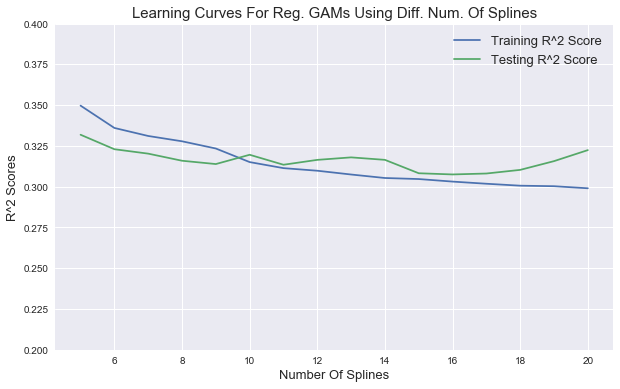

In [54]:
# plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(n_splines, r2_train, label="Training R^2 Score")
plt.plot(n_splines, r2_test,  label="Testing R^2 Score")
plt.ylabel("R^2 Scores",fontsize=13)
plt.xlabel("Number Of Splines",fontsize=13)
plt.ylim([0.2,0.4])
plt.title("Learning Curves For Reg. GAMs Using Diff. Num. Of Splines", fontsize=15)
plt.legend(fontsize=13)

We can see that increasing the number of splines doesnt seem to improve the predictive performance of the model past 10 or 12 splines.  


So in order to improve the predictive ability we'll need to turn to a different model.

###  Gradient Boosted Regression Trees

Let's try another model to see if we cant improve our $R^2$ score for our model.  One model that performs quite well is the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">Gradient Boosted Regression Tree</a>.  It is a nonlinear model based on decision trees and is one of the performing machine learning models avaiable. We can use Scikit-learns gradient boosted regressor:

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

GBR = GradientBoostingRegressor()

Now let's run a grid search using cross-valiation to find the optimal parameter values for our model:

In [57]:
# define the parameter values
paramters = {"n_estimators":[50,100,125,150,200],
             "max_depth"   :[3,5,7], 
             "loss"        :["ls", "lad", "huber", "quantile"]
            }

# defind the grid search and optimization metric
grid = GridSearchCV(estimator=GBR,
                    param_grid=paramters,
                    scoring="r2",
                    cv=5,
                    n_jobs=-1)

# perform the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 125, 150, 200], 'max_depth': [3, 5, 7], 'loss': ['ls', 'lad', 'huber', 'quantile']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

Now that we have the best model from our grid search over the trainin set let see how it performs on the test set:

In [58]:
y_pred = grid.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.7624921994166693


Again a definite improvement in the $R^2$ score!  While we have improved our prediction capabilities, one draw back to more complex models like Gradient Boosted Regressors is that they are less interperable.  Despite this draw back, Scikit-learn still allows to the find the relative importance of the features on the outcome of the model:

In [59]:
model = grid.best_estimator_
for coef in zip(X_train.columns, model.feature_importances_):
    print(coef)

('NGI', 0.22810117009023759)
('EI', 0.18868425762251614)
('WI', 0.10598472274970092)
('OPSFT', 0.10660449333103998)
('Year_Built', 0.11438224953111759)
('Zip_Code', 0.08256219175309458)
('Energy_Star', 0.17368091492229307)


The most important features for predicting green house gas emissions are the natural gas intensity followed by the energy start scored and the electicity intensity.  The zipcode and the year built have the least importance, which from our analysis above makes sense.

That's enough modeling for now! Overall we were able to come with a model that explains over 75% of the variance in the test set data.  Not bad!

--------------
## Conclusion And Recommendations <a class="anchor" id="fifth-bullet"></a>
--------------

In this blog post we analyzed the energy usage of multifamily buildings and developed a predictive model for these buildings green house gas emissions.  From the final heat map of the correlation matrix we can see that the Energy Star score is negatively correlated with enery usage intensity.  This makes sense as the energy star score is a measure of energy efficiceny of the building.  The energy usage intensity has a strong positive correlation to the natural gas usage intensity.  We can see that natural gas usage intensity and electricity usage intensity are uncorrlated.  This implies we could replace one with the other.  Therefore reducing natural gas consumption or replacing it with electricity could be the best answer to reducing energy usage intensity and green house gas emissions.  It should also be noted that year the residence was built did not have any correlation with energy usage intensity. This is probably due to the fact that the majority of residential buildings in New York City were built in a similar time period and before energy efficiency was a priority.


Since natural gas usage intensity is most highly correlated with energy usage intensity reducing it could improve building energy efficiency and reduce green house gas emissions (so long as the buildings' electricity comes from a clean energy source or atleast one with less emissions than natural gas). Some ways to reduce natural gas consumption include:

- Investing in more efficient heating and cooling services or slightly reducing the usage of either heating or cooling during the day when most people are not home. This is especially important in large buildings as HVAC systems have a larger volume of air to heat/cool.


- Another option is to reuse waste heat, such as reusing the vented air from electric clothes dryers, however, filtering and the air will be necessary and could alter the cost effectiveness of this approach.


- Replacing gas powered appliances such as stoves with more efficient electric ones is another option.  However, the source of electric power should also be considered to weigh the overall energy efficiency and enviromental impact.


- Another option is to replace gas powered water heaters by solar powered water heaters. While solar powered water heaters are not as cost effective in moderate climates, the presence of numerous roof top water tanks on New York City buildings may help make this option more financially competitive.  At the very least, it suggests that having roof top water tanks for solar powered water heaters is structurally possible, where as with individual houses this may not be the feasible.


- In addition, buying energy efficient refrigerators and dryers is also important as these are two of the largest energy consumers in ones home.
